In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import json

def parquet_dir_to_df(dirpath):
    df = pd.DataFrame()
    for filename in sorted(os.listdir(dirpath)):
        if filename.endswith('.parquet') or filename.endswith('.parquet.gzip'):
            filepath = os.path.join(dirpath, filename)
            df = df.append(pd.read_parquet(filepath))
    return df

# 1. Pre-process docker stats

In [2]:
docker_stats_json_path = 'docker_stats.json'
container_rename_dict = {
    '/social-network-backend': 'backend',
    '/social-network-db_0': 'db-master',
    '/social-network-db_1': 'db-slave-1',
    '/social-network-db_2': 'db-slave-2'
    }


In [3]:
docker_stats_list = json.load(open(docker_stats_json_path, 'r'))
docker_stats_df = pd.DataFrame(docker_stats_list)
docker_stats_df

,read,preread,pids_stats,blkio_stats,num_procs,storage_stats,cpu_stats,precpu_stats,memory_stats,name,id,networks
0,2023-07-10T11:28:37.452608628Z,2023-07-10T11:28:36.423697044Z,"{'current': 3, 'limit': 18446744073709551615}","{'io_service_bytes_recursive': [{'major': 254,...",0,{},"{'cpu_usage': {'total_usage': 13589684000, 'us...","{'cpu_usage': {'total_usage': 13194671000, 'us...","{'usage': 81653760, 'stats': {'active_anon': 1...",/social-network-backend,94031b5e84917a9f363a68c1a1ddc0f07a56995403d3b9...,"{'eth0': {'rx_bytes': 810, 'rx_packets': 11, '..."
1,2023-07-10T11:28:39.477172421Z,2023-07-10T11:28:38.465021004Z,"{'current': 5, 'limit': 18446744073709551615}","{'io_service_bytes_recursive': [{'major': 254,...",0,{},"{'cpu_usage': {'total_usage': 375504000, 'usag...","{'cpu_usage': {'total_usage': 374529000, 'usag...","{'usage': 19025920, 'stats': {'active_anon': 2...",/social-network-db_1,947ea409c2e2193b54ad63aef9eac14f60b271d6c20467...,"{'eth0': {'rx_bytes': 7344661, 'rx_packets': 2..."
2,2023-07-10T11:28:41.482584172Z,2023-07-10T11:28:40.480340296Z,"{'current': 8, 'limit': 18446744073709551615}","{'io_service_bytes_recursive': [{'major': 254,...",0,{},"{'cpu_usage': {'total_usage': 384520000, 'usag...","{'cpu_usage': {'total_usage': 384033000, 'usag...","{'usage': 24231936, 'stats': {'active_anon': 3...",/social-network-db_0,9782b2d340cb681a498f3258ccc4e03ae9471cf30e8135...,"{'eth0': {'rx_bytes': 12829, 'rx_packets': 170..."
3,2023-07-10T11:28:43.497090631Z,2023-07-10T11:28:42.485677047Z,"{'current': 5, 'limit': 18446744073709551615}","{'io_service_bytes_recursive': [{'major': 254,...",0,{},"{'cpu_usage': {'total_usage': 401519000, 'usag...","{'cpu_usage': {'total_usage': 400355000, 'usag...","{'usage': 18022400, 'stats': {'active_anon': 2...",/social-network-db_2,590f5c1bae852c4e54b273a155be4bb8d57bd56af05aa5...,"{'eth0': {'rx_bytes': 7342208, 'rx_packets': 1..."
4,2023-07-10T11:28:45.505399257Z,2023-07-10T11:28:44.50329709Z,"{'current': 3, 'limit': 18446744073709551615}","{'io_service_bytes_recursive': [{'major': 254,...",0,{},"{'cpu_usage': {'total_usage': 16612635000, 'us...","{'cpu_usage': {'total_usage': 16276384000, 'us...","{'usage': 81653760, 'stats': {'active_anon': 1...",/social-network-backend,94031b5e84917a9f363a68c1a1ddc0f07a56995403d3b9...,"{'eth0': {'rx_bytes': 810, 'rx_packets': 11, '..."
...,...,...,...,...,...,...,...,...,...,...,...,...
429,2023-07-10T11:42:25.960746554Z,2023-07-10T11:42:24.956897262Z,"{'current': 6, 'limit': 18446744073709551615}","{'io_service_bytes_recursive': [{'major': 254,...",0,{},"{'cpu_usage': {'total_usage': 32823023000, 'us...","{'cpu_usage': {'total_usage': 32821013000, 'us...","{'usage': 510869504, 'stats': {'active_anon': ...",/social-network-db_1,947ea409c2e2193b54ad63aef9eac14f60b271d6c20467...,"{'eth0': {'rx_bytes': 39871492, 'rx_packets': ..."
430,2023-07-10T11:42:27.985112846Z,2023-07-10T11:42:26.977810596Z,"{'current': 8, 'limit': 18446744073709551615}","{'io_service_bytes_recursive': [{'major': 254,...",0,{},"{'cpu_usage': {'total_usage': 469765000, 'usag...","{'cpu_usage': {'total_usage': 469765000, 'usag...","{'usage': 24285184, 'stats': {'active_anon': 6...",/social-network-db_0,9782b2d340cb681a498f3258ccc4e03ae9471cf30e8135...,"{'eth0': {'rx_bytes': 36167, 'rx_packets': 445..."
431,2023-07-10T11:42:30.006987833Z,2023-07-10T11:42:28.996651388Z,"{'current': 6, 'limit': 18446744073709551615}","{'io_service_bytes_recursive': [{'major': 254,...",0,{},"{'cpu_usage': {'total_usage': 30904248000, 'us...","{'cpu_usage': {'total_usage': 30902722000, 'us...","{'usage': 489316352, 'stats': {'active_anon': ...",/social-network-db_2,590f5c1bae852c4e54b273a155be4bb8d57bd56af05aa5...,"{'eth0': {'rx_bytes': 39997810, 'rx_packets': ..."
432,2023-07-10T11:42:32.015013292Z,2023-07-10T11:42:31.011800083Z,"{'current': 3, 'limit': 18446744073709551615}","{'io_service_bytes_recursive': [{'major': 254,...",0,{},"{'cpu_usage': {'total_usage': 497690207000, 'u...","{'cpu_usage': {

In [4]:


docker_stats_df = docker_stats_df[docker_stats_df['name'].isin(container_rename_dict)]
docker_stats_df['name'] = docker_stats_df['name'].map(container_rename_dict)

docker_stats_df['Timestamp'] = (pd.to_datetime(docker_stats_df['read']) - pd.Timestamp("1970-01-01", tz='utc')) // pd.Timedelta('1s')

docker_stats_df['cpu'] = docker_stats_df['cpu_stats'].apply(lambda x: x['cpu_usage']['total_usage'])

docker_stats_df['ram'] = docker_stats_df['memory_stats'].apply(lambda x: x['usage'])

docker_stats_df['net_rx_bytes'] = docker_stats_df['networks'].apply(lambda x: x['eth0']['rx_bytes'])
docker_stats_df['net_tx_bytes'] = docker_stats_df['networks'].apply(lambda x: x['eth0']['tx_bytes'])

docker_stats_df['disk_read'] = docker_stats_df['blkio_stats'].apply(lambda x: [y['value'] for y in x['io_service_bytes_recursive'] if y['op'] == 'read'][0])
docker_stats_df['disk_write'] = docker_stats_df['blkio_stats'].apply(lambda x: [y['value'] for y in x['io_service_bytes_recursive'] if y['op'] == 'write'][0])


drop_cols = ['read', 'preread', 'num_procs', 'storage_stats', 'pids_stats', 'precpu_stats', 'id', 'blkio_stats', 'cpu_stats', 'memory_stats', 'networks']
docker_stats_df.drop(columns=drop_cols, inplace=True)

In [5]:
docker_stats_df

,name,Timestamp,cpu,ram,net_rx_bytes,net_tx_bytes,disk_read,disk_write
0,backend,1688988517,13589684000,81653760,810,0,6815744,0
1,db-slave-1,1688988519,375504000,19025920,7344661,6481,1634304,4096
2,db-master,1688988521,384520000,24231936,12829,14685249,2707456,4096
3,db-slave-2,1688988523,401519000,18022400,7342208,5622,356352,4096
4,backend,1688988525,16612635000,81653760,810,0,6815744,0
...,...,...,...,...,...,...,...,...
429,db-slave-1,1688989345,32823023000,510869504,39871492,150909730,14925824,20480
430,db-master,1688989347,469765000,24285184,36167,14703073,2764800,4096
431,db-slave-2,1688989350,30904248000,489316352,39997810,146757818,704512,20480
432,backend,1688989352,497690207000,97792000,331661813,263169549,7536640,0


# 2. Pre-process locust stats

In [6]:
locust_stats_parquet_dir = 'loadtest_stats_history'

In [7]:
load_test_stats_df = parquet_dir_to_df(locust_stats_parquet_dir)

load_test_stats_df = load_test_stats_df[load_test_stats_df['User Count'] != 0]
load_test_stats_df = load_test_stats_df[load_test_stats_df['op_type'] == 'agg']

/var/folders/cv/_5p_r3x521s1plhh5ghyn8340000gn/T/ipykernel_71160/155342514.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_parquet(filepath))
/var/folders/cv/_5p_r3x521s1plhh5ghyn8340000gn/T/ipykernel_71160/155342514.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_parquet(filepath))
/var/folders/cv/_5p_r3x521s1plhh5ghyn8340000gn/T/ipykernel_71160/155342514.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_parquet(filepath))
/var/folders/cv/_5p_r3x521s1plhh5ghyn8340000gn/T/ipykernel_71160/155342514.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = d

In [8]:
load_test_stats_df['User Count'] = load_test_stats_df['User Count'].apply(lambda x: int(x) if x != 976 else 1000)

In [9]:
phase_starts = load_test_stats_df.groupby('User Count')['Timestamp'].min().reset_index()
phase_starts_dict = dict(zip(phase_starts['User Count'], phase_starts['Timestamp']))
phase_starts_dict

{1: 1688988597, 10: 1688988778, 100: 1688988959, 1000: 1688989139}

In [10]:
phase_starts_plus_60_dict = {k: v + 60 for k, v in phase_starts_dict.items()}
phase_starts_plus_60_dict

{1: 1688988657, 10: 1688988838, 100: 1688989019, 1000: 1688989199}

In [11]:
phases = sorted(phase_starts_dict.keys())
starts = [phase_starts_dict[k] for k in phases]
true_starts = [phase_starts_plus_60_dict[k] for k in phases]
ends = [phase_starts_dict[k] for k in phases[1:]] + [load_test_stats_df['Timestamp'].max()]
phase_interval_dict = dict(zip(phases, list(zip(true_starts, ends))))
phase_interval_dict

{1: (1688988657, 1688988778),
 10: (1688988838, 1688988959),
 100: (1688989019, 1688989139),
 1000: (1688989199, 1688989319)}

In [12]:
drop_cols = ['Type', '66%', '75%', '80%', '90%', '98%', '99%', '99.9%', '99.99%', '100%',
             'Total Failure Count', 'Total Median Response Time', 'Total Average Response Time',
             'Total Min Response Time', 'Total Max Response Time', 'Total Average Content Size',
             'is_agg', 'is_user_get', 'is_user_search', 'get_id', 'search_fname', 'search_lname',
             'op_type', 'Failures/s']

load_test_stats_df.drop(columns=drop_cols, inplace=True)

In [13]:
load_test_stats_df['User Count'].value_counts(dropna=False)

1       159
10      107
100      73
1000     61
Name: User Count, dtype: int64

In [14]:
load_test_stats_df['cutoff_time'] = load_test_stats_df['User Count'].map(phase_starts_plus_60_dict)
load_test_stats_df = load_test_stats_df[load_test_stats_df['Timestamp'] >= load_test_stats_df['cutoff_time']]
load_test_stats_df.drop(columns=['cutoff_time'], inplace=True)

# 3. Process docker stats

In [15]:
def get_phase(timestamp, phase_interval_dict):
    for phase, interval in phase_interval_dict.items():
        if interval[0] <= timestamp <= interval[1]:
            return phase
    return None

In [16]:
docker_stats_df['User Count'] = docker_stats_df['Timestamp'].apply(lambda x: get_phase(x, phase_interval_dict))
docker_stats_df.dropna(inplace=True, subset=['User Count'])
docker_stats_df['User Count'] = docker_stats_df['User Count'].astype(int)

In [17]:
docker_stats_df

,name,Timestamp,cpu,ram,net_rx_bytes,net_tx_bytes,disk_read,disk_write,User Count
72,backend,1688988658,70816573000,92012544,16784904,13856975,7536640,0,1
73,db-slave-1,1688988660,3231330000,414531584,8888266,10438307,13828096,4096,1
74,db-master,1688988662,416274000,24260608,16695,14687987,2732032,4096,1
75,db-slave-2,1688988664,2027968000,242143232,8908235,5692007,561152,4096,1
76,backend,1688988666,74413600000,91975680,18158965,15013078,7536640,0,1
...,...,...,...,...,...,...,...,...,...
411,db-slave-2,1688989310,30418384000,489336832,39533755,144603734,704512,20480,1000
412,backend,1688989312,480567477000,101048320,328721209,260756722,7536640,0,1000
413,db-slave-1,1688989314,32672084000,510861312,39761174,150345754,14925824,20480,1000
414,db-master,1688989316,467702000,24285184,35321,14702415,2764800,4096,1000


In [18]:
load_test_stats_df

,Timestamp,User Count,Requests/s,50%,95%,Total Request Count
75335,1688988657,1,46.1,7.0,50.0,2696
78051,1688988658,1,45.1,7.0,50.0,2747
80815,1688988659,1,45.5,7.0,50.0,2795
83631,1688988660,1,45.4,7.0,50.0,2848
86499,1688988661,1,45.3,7.0,50.0,2901
...,...,...,...,...,...,...
8276670,1688989306,1000,90.1,3100.0,16000.0,71751
8334401,1688989309,1000,108.4,3000.0,22000.0,71896
8392526,1688989313,1000,95.5,5900.0,23000.0,72522
8450896,1688989316,1000,111.7,16000.0,23000.0,72896


# 4. Save processed datasets

In [20]:
load_test_stats_df.to_csv('processed_data/load_test_stats.csv', index=False)
docker_stats_df.to_csv('processed_data/docker_stats.csv', index=False)

# 5. Plotting

In [21]:
def plot2(df, column, title, category_col, sharey=True, logy=False):
    df = df.rename(columns={column: title})

    plot = sns.catplot(
        data=df, kind="box",
        x=category_col, y=title, hue=category_col, col="User Count",
        sharey=sharey
    )

    [ax.grid(axis='y') for ax in plot.axes.flatten()]
    if logy:
        [ax.set_yscale('log') for ax in plot.axes.flatten()]

    return plot

In [24]:
docker_stats_df = docker_stats_df.sort_values('name')

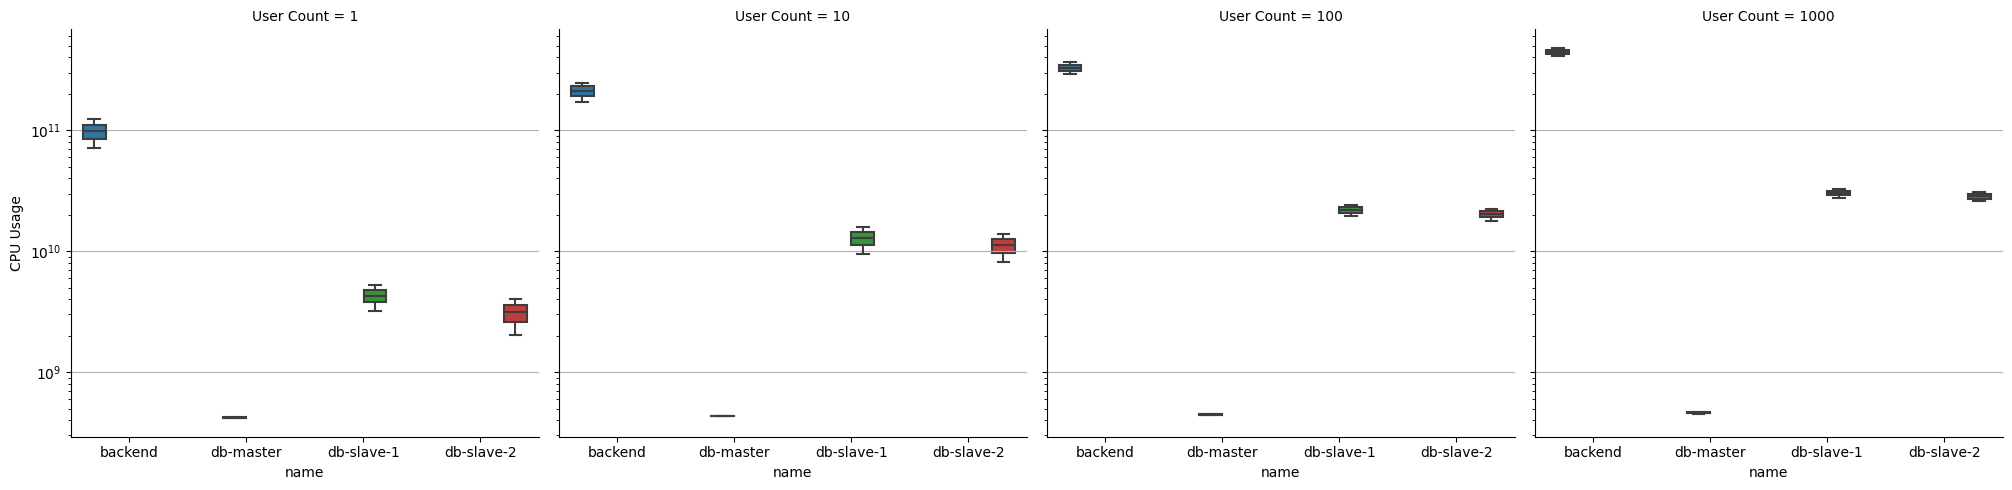

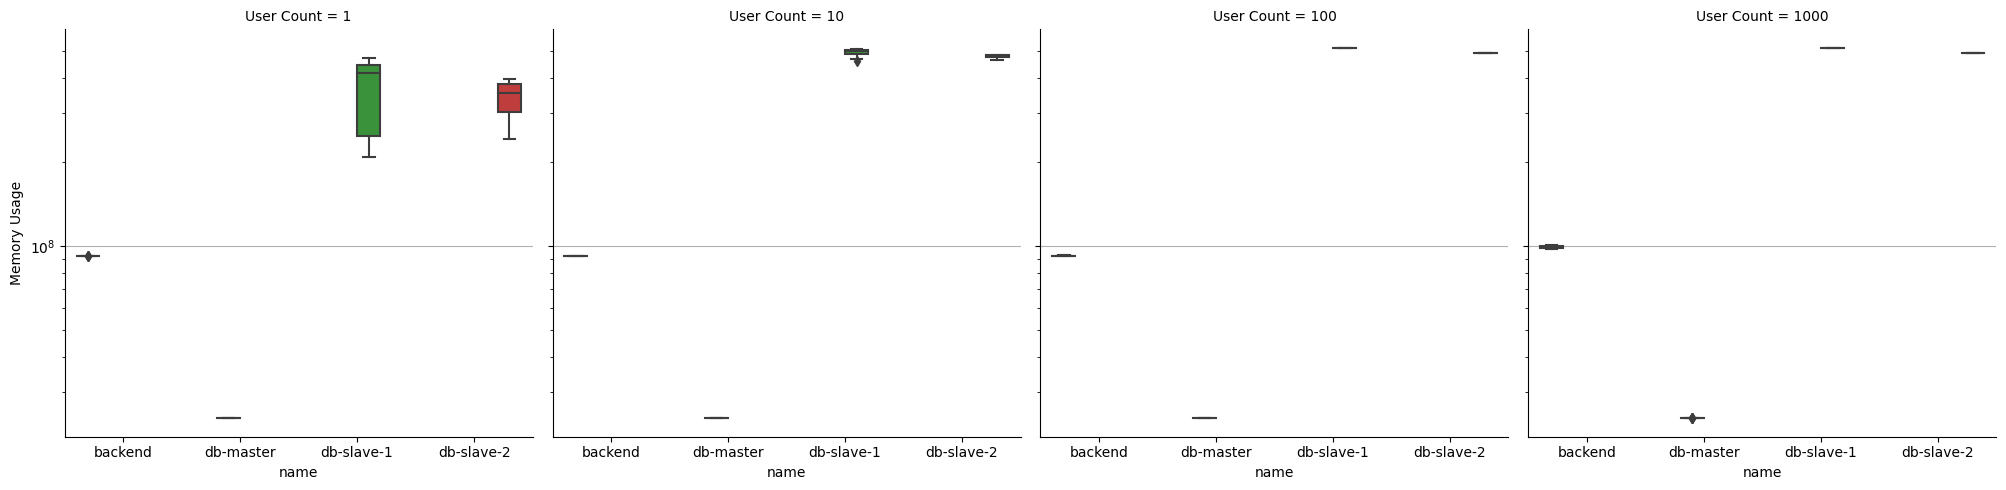

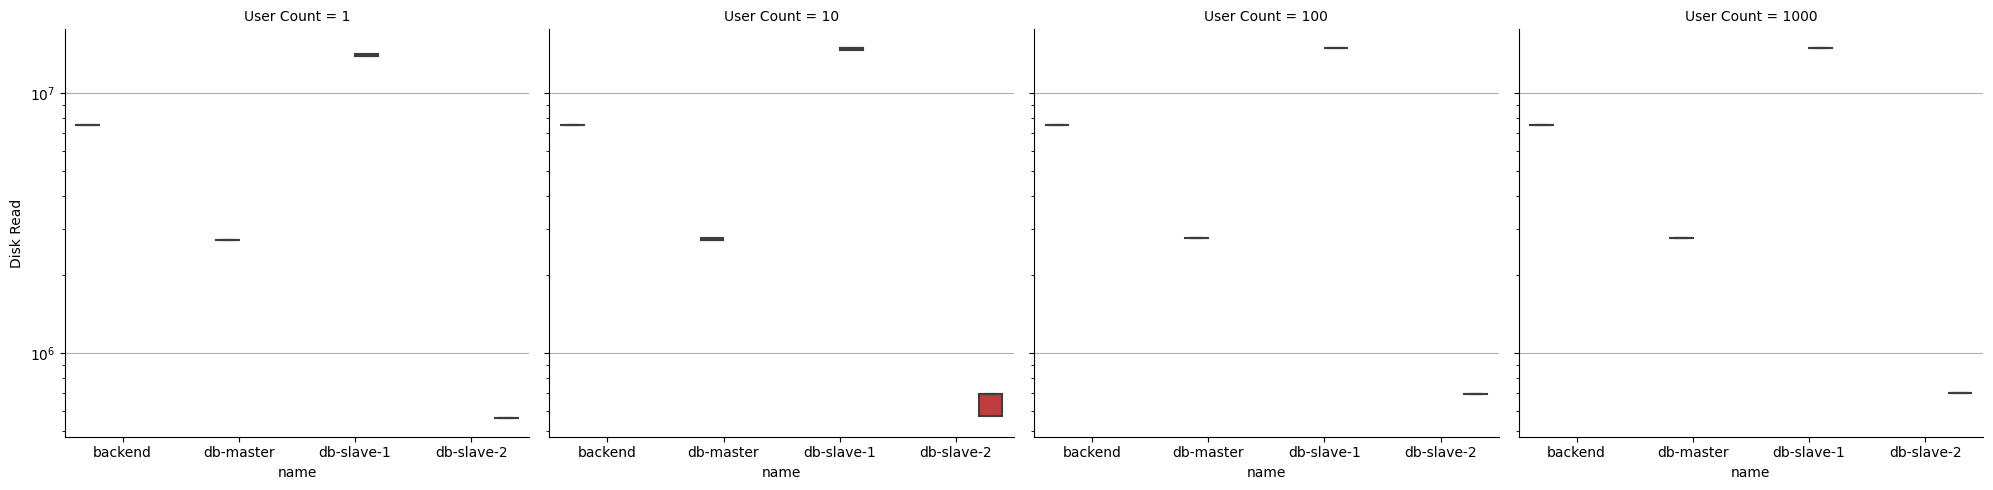

In [40]:
ax0 = plot2(docker_stats_df, 'cpu', 'CPU Usage', 'name', sharey=True, logy=True)
ax1 = plot2(docker_stats_df, 'ram', 'Memory Usage', 'name', sharey=True, logy=True)
ax2 = plot2(docker_stats_df, 'disk_read', 'Disk Read', 'name', sharey=True, logy=True)

ax0.savefig('result_plots/container_cpu_usage.png')
ax1.savefig('result_plots/container_memory_usage.png')
ax2.savefig('result_plots/container_disk_read.png')

In [26]:
load_test_stats_df['name'] = 'async slaves (2)'

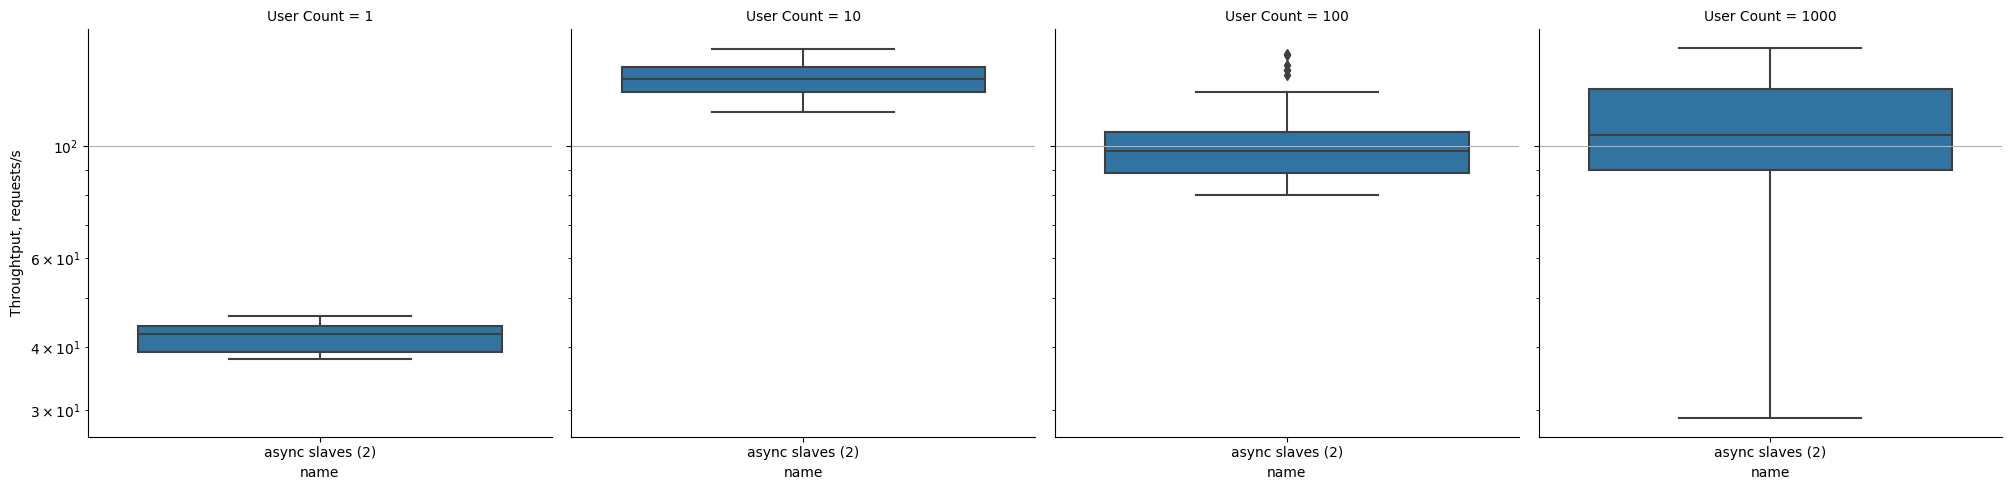

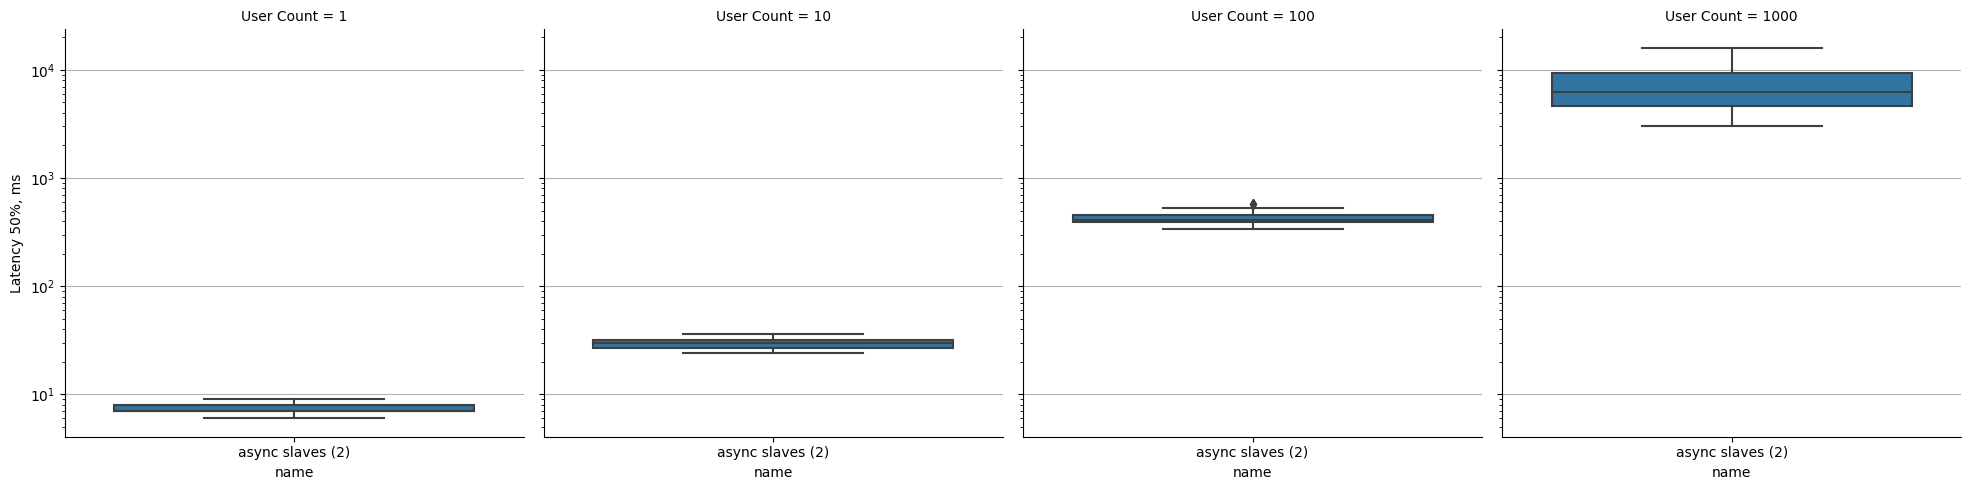

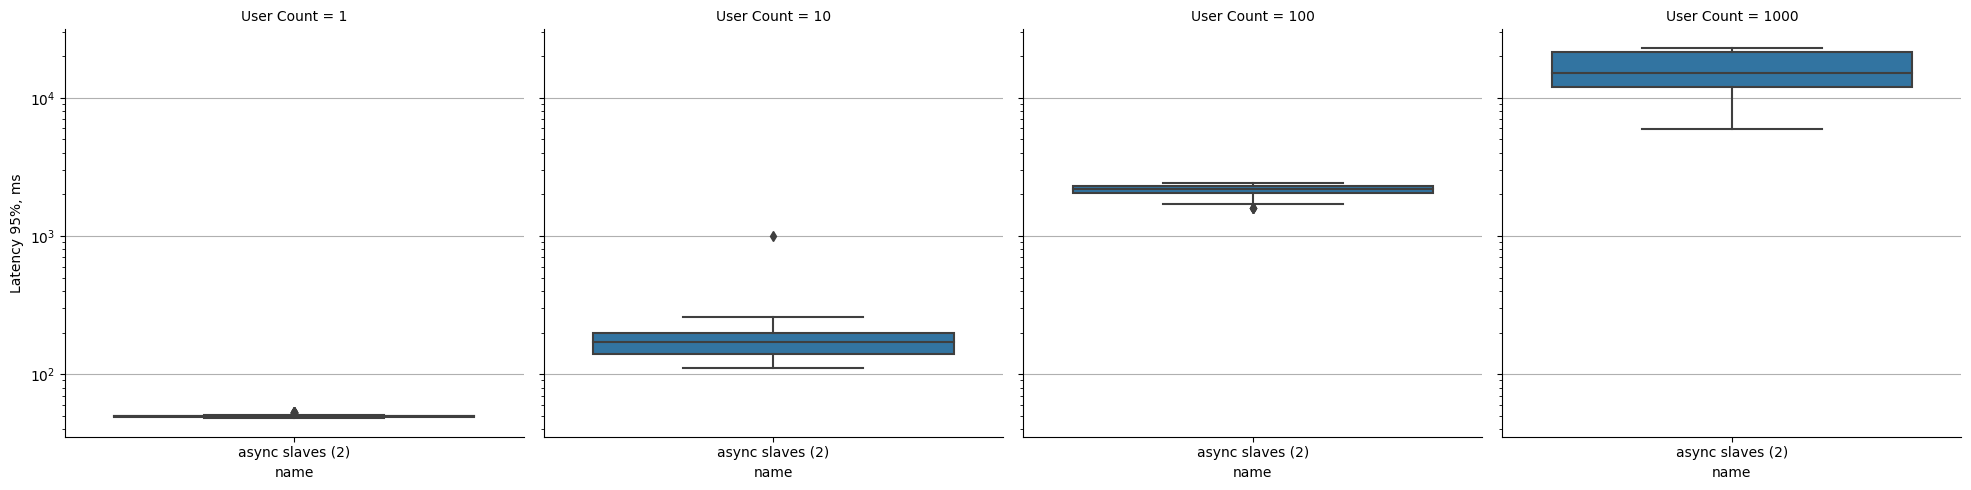

In [34]:
ax0 = plot2(load_test_stats_df, 'Requests/s', 'Throughtput, requests/s', 'name', sharey=True, logy=True)
ax1 = plot2(load_test_stats_df, '50%', 'Latency 50%, ms', 'name', sharey=True, logy=True)
ax2 = plot2(load_test_stats_df, '95%', 'Latency 95%, ms', 'name', sharey=True, logy=True)

ax0.savefig('result_plots/client_throughput.png')
ax1.savefig('result_plots/client_latency_50.png')
ax2.savefig('result_plots/client_latency_95.png')

# Contrast

In [28]:
load_test_stats__master_df = pd.read_csv('../001_load_test_search_get_without_replica/processed_data/load_test_stats.csv')

In [31]:
load_test_stats__master_df['name'] = 'master only'

In [37]:
df = pd.concat([load_test_stats__master_df, load_test_stats_df])

In [38]:
df

,Timestamp,User Count,Requests/s,50%,95%,Total Request Count,name
0,1688813186,1,49.9,5.0,47.0,3111,master only
1,1688813187,1,50.1,5.0,47.0,3159,master only
2,1688813188,1,49.6,5.0,47.0,3216,master only
3,1688813189,1,49.1,5.0,47.0,3273,master only
4,1688813190,1,48.8,5.0,47.0,3327,master only
...,...,...,...,...,...,...,...
8276670,1688989306,1000,90.1,3100.0,16000.0,71751,async slaves (2)
8334401,1688989309,1000,108.4,3000.0,22000.0,71896,async slaves (2)
8392526,1688989313,1000,95.5,5900.0,23000.0,72522,async slaves (2)
8450896,1688989316,1000,111.7,16000.0,23000.0,72896,async slaves (2)


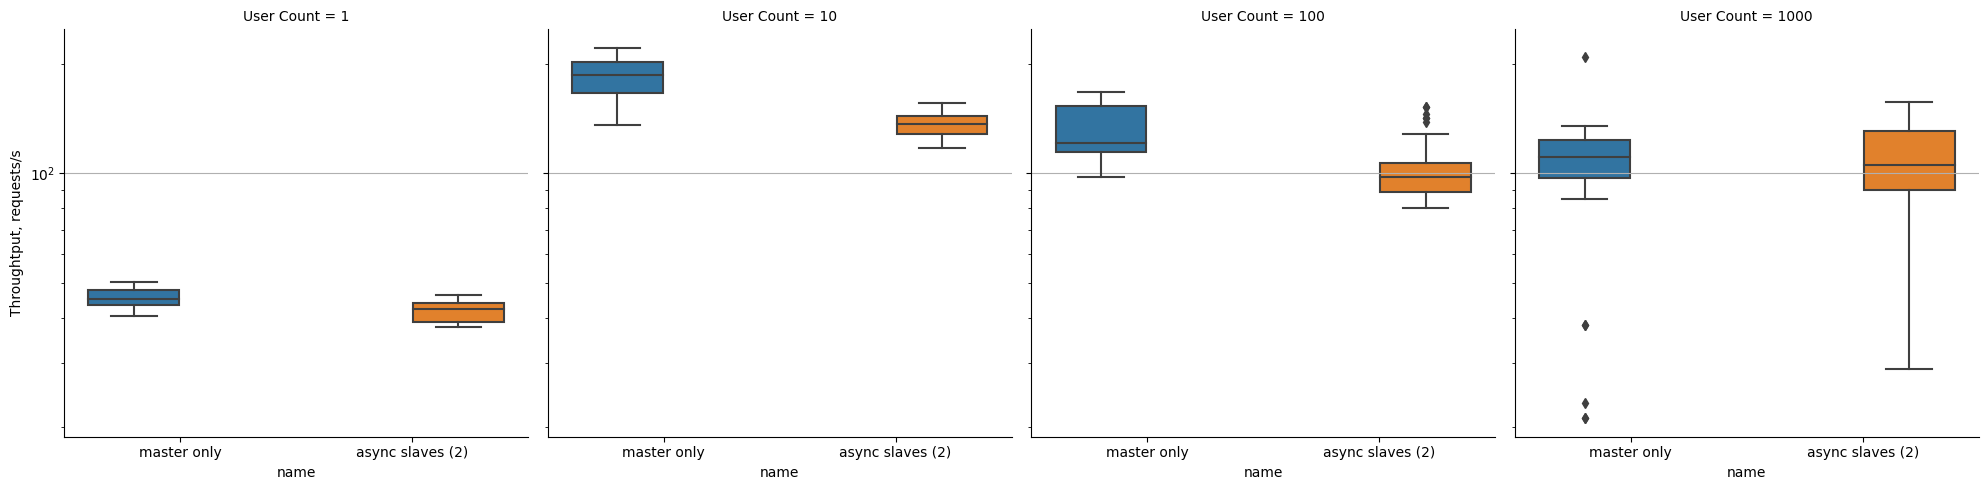

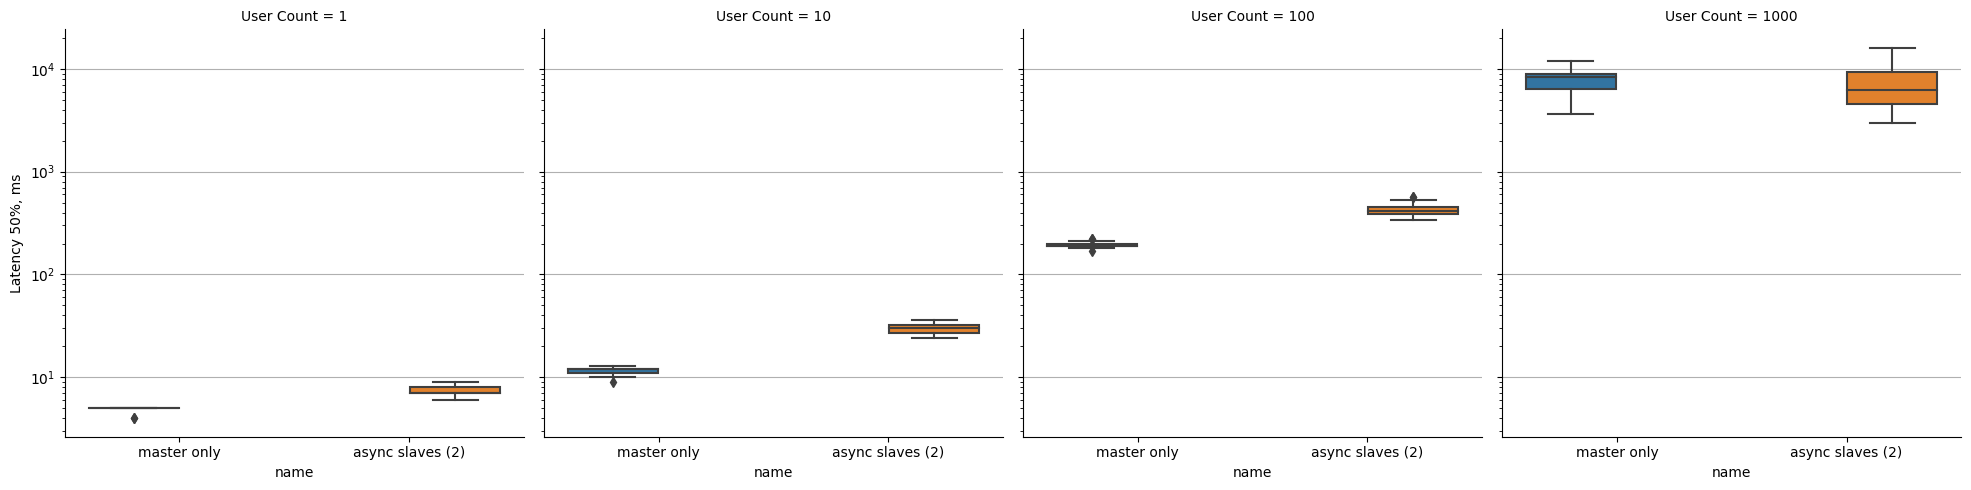

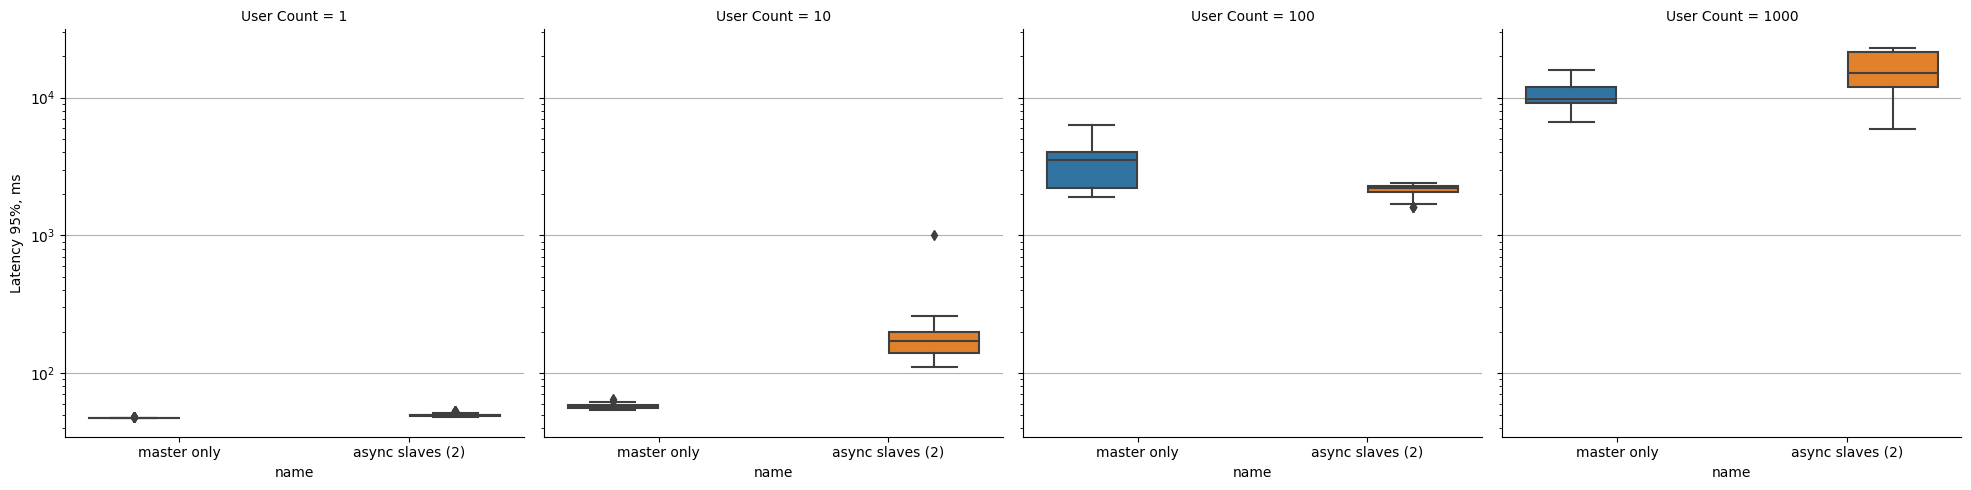

In [39]:
ax0 = plot2(df, 'Requests/s', 'Throughtput, requests/s', 'name', sharey=True, logy=True)
ax1 = plot2(df, '50%', 'Latency 50%, ms', 'name', sharey=True, logy=True)
ax2 = plot2(df, '95%', 'Latency 95%, ms', 'name', sharey=True, logy=True)

ax0.savefig('result_plots/client_contrast_throughput.png')
ax1.savefig('result_plots/client_contrast_latency_50.png')
ax2.savefig('result_plots/client_contrast_latency_95.png')